<a href="https://colab.research.google.com/github/parimalakettymuthu/MachineLearning-Projects/blob/main/MultiLabel_Classification_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
#sys.path.append('/content/drive/MyDrive/NLP/custom-functions')

In [3]:
import pandas as pd
from pathlib import Path
import joblib
# Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import  vocab

import random
import numpy as np
import pandas as pd
import joblib
from collections import Counter


from pathlib import Path
import sys

from sklearn.model_selection import train_test_split
!pip install wandb -qq
import wandb

In [4]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')   
  base_path = '/content/drive/MyDrive/NLP'
  sys.path.append('/content/drive/MyDrive/NLP/user-defined-fns')
  sys.path.append('/content/drive/MyDrive/NLP/user-defined-fn')
  sys.path.append('/content/drive/MyDrive/NLP/user-defined')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
base_folder = Path(base_path)
assignment_fldr = base_folder/ 'assignment6'
custom_fldr = base_folder/ 'user-defined-fn'

#Check contents in data folder
for entries in custom_fldr.iterdir():
  print(entries.name)

data_preparation_imdb_rev0.py
.ipynb_checkpoints
__pycache__


In [6]:
#sys.path.append('/content/drive/MyDrive/NLP/custom-functions')
sys.path = list(set(sys.path))

In [7]:
sys.path

['',
 '/content/drive/MyDrive/NLP/user-defined',
 '/usr/lib/python3.9/lib-dynload',
 '/usr/lib/python39.zip',
 '/usr/local/lib/python3.9/dist-packages',
 '/content',
 '/usr/lib/python3/dist-packages',
 '/root/.ipython',
 '/usr/lib/python3.9',
 '/usr/local/lib/python3.9/dist-packages/IPython/extensions',
 '/content/drive/MyDrive/NLP/user-defined-fn',
 '/content/drive/MyDrive/NLP/user-defined-fns',
 '/env/python']

In [8]:
!pip install torchmetrics -qq

In [9]:
from Trainer_v2 import Trainer
from ff_3_layer_sequential_model import MLPCustom

In [10]:
from data_preparation_imdb_rev0 import *

In [11]:
df_multilable_data = assignment_fldr/ 'df_multilabel_hw_cleaned.joblib'
multiLabel_Data = joblib.load(df_multilable_data)

In [12]:
multiLabel_Data.columns

Index(['cleaned_text', 'Tags', 'Tag_Number'], dtype='object')

In [13]:
multiLabel_Data.shape

(47427, 3)

In [14]:
import ast
# assume 'df' is your pandas DataFrame
multiLabel_Data['Tag_Number'] = multiLabel_Data['Tag_Number'].apply(lambda x: [int(i) for i in ast.literal_eval(x)])

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

# assume 'labels' is your list of labels (i.e., 'Tag_Number' column after conversion to integers)
mlb = MultiLabelBinarizer()
one_hot_labels= mlb.fit_transform(multiLabel_Data['Tag_Number'])
for i in range(len(mlb.classes_)):
    multiLabel_Data[f"one_hot_{mlb.classes_[i]}"] = one_hot_labels[:, i]

In [16]:
multiLabel_Data.columns

Index(['cleaned_text', 'Tags', 'Tag_Number', 'one_hot_0', 'one_hot_1',
       'one_hot_2', 'one_hot_3', 'one_hot_4', 'one_hot_5', 'one_hot_6',
       'one_hot_7', 'one_hot_8', 'one_hot_9'],
      dtype='object')

In [17]:
#multiLabel_Data['Tag_Number_encoded']

In [18]:
#multiLabel_Data['Tag_Number_encoded'].shape


In [19]:
X_final = multiLabel_Data['cleaned_text'].values

In [20]:
y_final = multiLabel_Data.loc[:, 'one_hot_0':'one_hot_9'].values
unique_labels = np.unique(y_final)
print(unique_labels)

[0 1]


In [21]:
print(type(y_final), y_final.shape)

<class 'numpy.ndarray'> (47427, 10)


#Create Train/Test/Valid Split

In [22]:
#X_train, x_valid_test, y_train, y_valid_test = train_test_split(X_final, y_final, test_size = 0.4, stratify = y_final)
X_train, x_valid_test, y_train, y_valid_test = train_test_split(X_final, y_final, test_size = 0.4)

In [23]:
#X_valid, X_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, test_size = 0.5, stratify = y_valid_test)
X_valid, X_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, test_size = 0.5)

In [24]:
print("Train set shape: ", X_train.shape, "Split %: ", len(X_train)/len(X_final))
print("Validation set shape: ", X_valid.shape,"Split %: ", len(X_valid)/len(X_final))
print("Test set shape: ", X_test.shape, "Split %: ", len(X_test)/len(X_final))

Train set shape:  (28456,) Split %:  0.59999578299281
Validation set shape:  (9485,) Split %:  0.19999156598562
Test set shape:  (9486,) Split %:  0.20001265102156998


In [25]:
trainset = CustomDataset(X_train,y_train)
validset = CustomDataset(X_valid,y_valid)
testset = CustomDataset(X_test,y_test)

In [26]:
print(np.unique(y_train), np.unique(y_valid), np.unique(y_test))

[0 1] [0 1] [0 1]


#Create vocab

In [27]:
multilabel_vocab = get_vocab(trainset, min_freq=2)

In [28]:
len(multilabel_vocab)

90538

In [29]:
valid_multilabel_vocab = get_vocab(validset, min_freq=2)

#Meta Data

In [30]:
from types import SimpleNamespace

hyperparameters = SimpleNamespace(
    # model Parameters
    EMBED_DIM=300,
    VOCAB_SIZE=len(multilabel_vocab),
    OUTPUT_DIM=10,
    HIDDEN_DIM1=200,
    HIDDEN_DIM2=100,
    NON_LINEARITY=F.relu,
    
    # training 
    EPOCHS=5,
    BATCH_SIZE=128,
    LEARNING_RATE=0.001,
    WEIGHT_DECAY=0.000,
    CLIP_TYPE = 'value',
    CLIP_VALUE = 10,
    PATIENCE=5,
    MOMENTUM=0,  
)

#Trainer Configuration

In [31]:
'''def collate_batch_multilabel(batch, vocab, num_classes):
    labels, texts = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.float32)
    #labels = torch.tensor(labels, dtype=torch.float32).to(torch.float32)
    labels = torch.nn.functional.one_hot(labels.to(torch.int64), num_classes=num_classes)

    list_of_list_of_indices = [text_pipeline(text, vocab) for text in texts]

    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    texts = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    return (texts, offsets), labels.to(torch.float32)'''

'def collate_batch_multilabel(batch, vocab, num_classes):\n    labels, texts = zip(*batch)\n    labels = torch.tensor(labels, dtype=torch.float32)\n    #labels = torch.tensor(labels, dtype=torch.float32).to(torch.float32)\n    labels = torch.nn.functional.one_hot(labels.to(torch.int64), num_classes=num_classes)\n\n    list_of_list_of_indices = [text_pipeline(text, vocab) for text in texts]\n\n    offsets = [0] + [len(i) for i in list_of_list_of_indices]\n    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)\n    texts = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])\n\n    return (texts, offsets), labels.to(torch.float32)'

In [32]:
def collate_batch_multilabel(batch, vocab):
    labels, texts = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.float32)
    list_of_list_of_indices = [text_pipeline(text, vocab) for text in texts]
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    texts = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])
    return (texts, offsets), labels

In [33]:
from functools import partial
# Fix seed value
Trainer.set_seed()

collate_fn = partial(collate_batch_multilabel, vocab=multilabel_vocab)
#train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           #batch_size=hyperparameters.BATCH_SIZE,
                                           #collate_fn=collate_fn,
                                           #shuffle=True)
#collate_fn = partial(collate_batch_multilabel, vocab=valid_multilabel_vocab)
#valid_loader = torch.utils.data.DataLoader(dataset=validset,
 #                                          batch_size=hyperparameters.BATCH_SIZE,
  #                                         collate_fn=lambda batch: collate_batch_multilabel(batch, valid_multilabel_vocab),
   #                                        shuffle=False)
#valid_loader = torch.utils.data.DataLoader(dataset=validset,
                                          # batch_size=hyperparameters.BATCH_SIZE,
                                          # collate_fn=collate_fn,
                                          # shuffle=True)

# Data Loader
train_loader, valid_loader = get_loaders(trainset, validset, batch_size_= hyperparameters.BATCH_SIZE, 
                                         collate_fn=collate_fn)

# cross entropy loss function
#loss_function = nn.CrossEntropyLoss()
loss_function = torch.nn.BCEWithLogitsLoss()
# model
model_imdb = MLPCustom(hyperparameters.EMBED_DIM,
                       hyperparameters.VOCAB_SIZE,
                       hyperparameters.HIDDEN_DIM1,
                       hyperparameters.HIDDEN_DIM2,
                       hyperparameters.OUTPUT_DIM,
                       hyperparameters.NON_LINEARITY)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


# apply initialization recursively  to all modules
model_imdb.apply(init_weights)

# Intialize stochiastic gradient descent optimizer
optimizer = torch.optim.Adam(model_imdb.parameters(),
                             lr=hyperparameters.LEARNING_RATE,
                             weight_decay=hyperparameters.WEIGHT_DECAY,
                             )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [34]:
#print(train_loader.shape, train_loader.shape)
for (texts, offsets), labels in valid_loader:
  print(labels, texts, offsets)
  break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]) tensor([1058,  283,  302,  ...,    0,   49,    0]) tensor([    0,    58,   110,   309,   395,   457,   589,   736,   761,   795,
          914,   952,  1016,  1027,  1173,  1234,  1318,  1416,  1792,  1843,
         1868,  1904,  2010,  2121,  2169,  2314,  2450,  2473,  2603,  2949,
         2972,  2995,  3086,  3132,  3220,  3259,  3352,  3375,  3414,  3480,
         3548,  3685,  3724,  3801,  4533,  4557,  4628,  4747,  4856,  4883,
         5149,  5258,  5286,  5315,  5364,  5608,  5718,  5755,  5816,  5912,
         5925,  5961,  6100,  6145,  6168,  6384,  6430,  6502,  6684,  7328,
         7393,  7436,  7479,  7541,  7614,  7685,  7704,  7920,  7999,  8035,
         8059,  8108,  8224,  8330,  8464,  8786,  8839,  8913,  9068, 

<ipython-input-32-0afa194fa4de>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  labels = torch.tensor(labels, dtype=torch.float32)


#Training Model

In [35]:
trainer = Trainer(model=model_imdb, optimizer=optimizer,
                  criterion=loss_function, device=device)

In [36]:
#from torchmetrics.classification import Accuracy
from torchmetrics.classification import HammingDistance
run_folder = assignment_fldr/'rev2'
run_folder.mkdir(exist_ok=True)

# set loaders
trainer.set_loaders(train_loader, valid_loader)

# set metric -- OPTIONAL
#train_metric = Accuracy(task='binary')
train_metric = HammingDistance(mode='multilabel',task='multilabel', num_labels=10,compute_on_step=False)
#valid_metric = Accuracy(task='binary')
valid_metric = HammingDistance(mode='multilabel',task='multilabel', num_labels=10,compute_on_step=False)
trainer.set_metric(train_metric.to(device), valid_metric.to(device))

# set checkpoint -- OPTIONAL
trainer.set_checkpoint(save_path=run_folder,
                       save_best=True, save_every_n_epochs=1, save_last_epoch=False)

# set early stopping -- OPTIONAL
trainer.set_early_stopping(patience = hyperparameters.PATIENCE)

# set gradient Clipping  -- OPTIONAL
trainer.set_gradient_clipping(hyperparameters.CLIP_TYPE, hyperparameters.CLIP_VALUE, norm_type=2)

In [37]:
trainer.sanity_check(num_classes=2)

Actual loss: 0.7231895327568054
Expected Theoretical loss: 0.6931471805599453


In [38]:
trainer.train(num_epochs=hyperparameters.EPOCHS, multilabel=True)

Epoch 1/5 - Train Loss: 0.5762, Train Metric: 0.2655, Train Time: 0:01:46.584139
Epoch 1/5 - Val Loss: 0.2285, Val Metric: 0.0729, Val Time: 0:00:00.962347

Epoch 2/5 - Train Loss: 0.2331, Train Metric: 0.0830, Train Time: 0:01:23.711080
Epoch 2/5 - Val Loss: 0.1648, Val Metric: 0.0605, Val Time: 0:00:01.166872

Epoch 3/5 - Train Loss: 0.1770, Train Metric: 0.0626, Train Time: 0:01:19.985982
Epoch 3/5 - Val Loss: 0.1447, Val Metric: 0.0528, Val Time: 0:00:00.942895

Epoch 4/5 - Train Loss: 0.1500, Train Metric: 0.0531, Train Time: 0:01:21.166316
Epoch 4/5 - Val Loss: 0.1319, Val Metric: 0.0481, Val Time: 0:00:00.965853

Epoch 5/5 - Train Loss: 0.1329, Train Metric: 0.0472, Train Time: 0:01:19.129662
Epoch 5/5 - Val Loss: 0.1235, Val Metric: 0.0451, Val Time: 0:00:01.309178



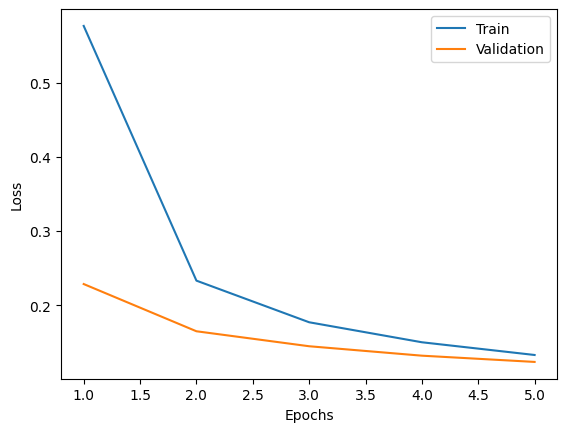

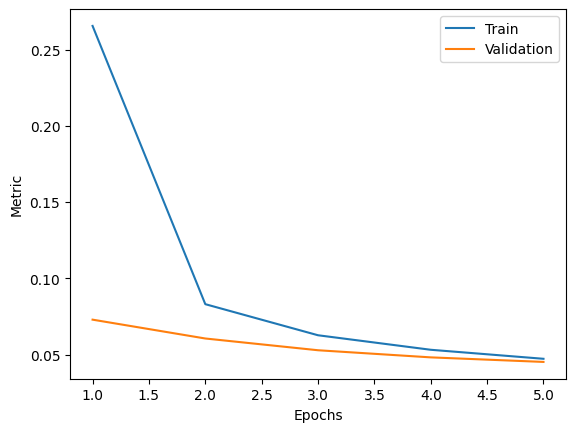

In [39]:
trainer.plot_history()

In [40]:
trainer.best_epoch

5

In [49]:
file = 'checkpoint_' + str(trainer.timestamp) + '_best.pt'
trainer.load_checkpoint(run_folder /file)

Loaded checkpoint from '/content/drive/MyDrive/NLP/assignment6/rev2/checkpoint_2023-04-09_23-14-12_best.pt'.


In [50]:
trainer.train(num_epochs=10, multilabel=True)

Epoch 1/10 - Train Loss: 0.1195, Train Metric: 0.0425, Train Time: 0:01:23.544345
Epoch 1/10 - Val Loss: 0.1154, Val Metric: 0.0422, Val Time: 0:00:00.963920

Epoch 2/10 - Train Loss: 0.1067, Train Metric: 0.0377, Train Time: 0:01:25.170896
Epoch 2/10 - Val Loss: 0.1107, Val Metric: 0.0400, Val Time: 0:00:01.428602

Epoch 3/10 - Train Loss: 0.0969, Train Metric: 0.0349, Train Time: 0:01:19.483922
Epoch 3/10 - Val Loss: 0.1088, Val Metric: 0.0389, Val Time: 0:00:00.944626

Epoch 4/10 - Train Loss: 0.0879, Train Metric: 0.0313, Train Time: 0:01:36.732818
Epoch 4/10 - Val Loss: 0.1052, Val Metric: 0.0378, Val Time: 0:00:01.720965

Epoch 5/10 - Train Loss: 0.0811, Train Metric: 0.0290, Train Time: 0:01:20.414917
Epoch 5/10 - Val Loss: 0.1045, Val Metric: 0.0370, Val Time: 0:00:00.953255

EarlyStopping counter: 1 out of 5
Epoch 6/10 - Train Loss: 0.0743, Train Metric: 0.0264, Train Time: 0:01:20.376981
Epoch 6/10 - Val Loss: 0.1046, Val Metric: 0.0370, Val Time: 0:00:01.759468

Epoch 7/10 -

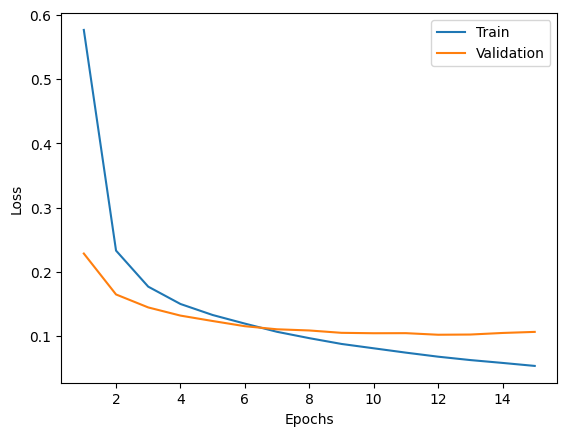

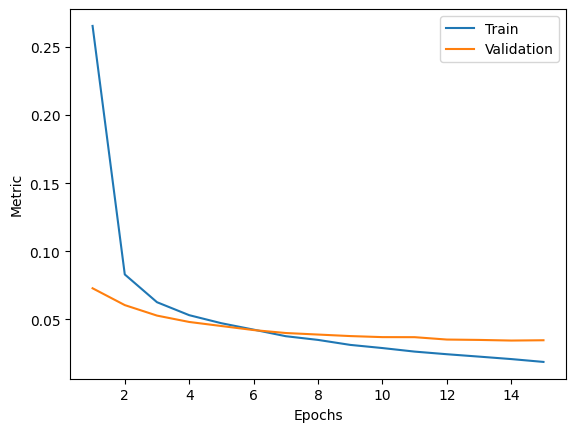

In [51]:
trainer.plot_history()

In [52]:
trainer.best_epoch

11

#Get Accuracy, Predictions

In [60]:
testset = CustomDataset(X_test, y_test)

In [61]:
test_multilabel_vocab = get_vocab(testset, min_freq=2)

In [62]:
collate_fn = partial(collate_batch_multilabel, vocab=test_multilabel_vocab)
test_loader = get_test_loaders(testset, batch_size_=hyperparameters.BATCH_SIZE,
                               collate_fn=collate_fn)
#collate_fn = partial(collate_batch_multilabel, vocab=test_multilabel_vocab)
#test_loader = torch.utils.data.DataLoader(dataset=validset,
                                          # batch_size=hyperparameters.BATCH_SIZE,
                                           #collate_fn=collate_fn,
                                          # shuffle=False)
#test_loader = torch.utils.data.DataLoader(dataset=validset,
 #                                          batch_size=hyperparameters.BATCH_SIZE,
  #                                         collate_fn=lambda batch: collate_batch_multilabel(batch, test_multilabel_vocab),
   #                                        shuffle=True)

In [63]:
# Get the prediction and accuracy for the test dataset

predictions_train, target_train = trainer.predict(
    train_loader, return_targets=True)
predictions_valid, target_valid = trainer.predict(
    valid_loader, return_targets=True)
predictions_test, target_test = trainer.predict(
    test_loader, return_targets=True)

In [64]:
print(target_train.shape, predictions_train.shape)
print(target_valid.shape, predictions_valid.shape)
print(target_test.shape, predictions_test.shape)

torch.Size([28456, 10]) torch.Size([28456])
torch.Size([9485, 10]) torch.Size([9485])
torch.Size([9486, 10]) torch.Size([9486])


In [65]:
import torchmetrics

In [66]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
from torchmetrics.functional.classification import multilabel_f1_score, multilabel_hamming_distance
#num_classes = target_train.shape[-1]
threshold = 0.5
average='micro'
#binary_predictions_train = (predictions_train > threshold).int()
#binary_predictions_valid = (predictions_valid > threshold).int()
#binary_predictions_test = (predictions_test > threshold).int()
import torch.nn.functional as F

num_classes = target_train.shape[-1]
binary_target_train = torch.zeros(target_train.shape[0], num_classes, dtype=torch.float32)
binary_target_train.scatter_(1, torch.tensor(target_train, dtype=torch.int64), 1)
# compute binary predictions
binary_predictions_train = (predictions_train > threshold).int()
#print("Train binary predictions: ", binary_predictions_train.shape)
print("Train binary targets: ", binary_target_train.shape)
print("Train binary predictions: ", binary_predictions_train.shape)
f1_score_train = f1_score(binary_target_train, binary_predictions_train, average='micro')
hamming_distance_train = multilabel_hamming_distance(binary_predictions_train, target_train, num_labels=num_classes)
print("Train F1 Score: ",f1_score_train, " Train hamming distance: ", hamming_distance_train)
#f1_score_train = multilabel_f1_score(binary_predictions_train, target_train,num_labels=num_classes, threshold=threshold, average=average)
f1_score_train = f1_score(binary_target_train, binary_predictions_train, average='micro')
hamming_distance_train = multilabel_hamming_distance(binary_predictions_train, target_train, num_labels=num_classes)
print("Train F1 Score: ",f1_score_train, " Train hamming distance: ", hamming_distance_train)

num_classes = target_valid.shape[-1]
binary_predictions_valid = F.one_hot(predictions_valid, num_classes=num_classes)
print("Valid binary predictions: ", binary_predictions_valid.shape)
f1_score_valid = multilabel_f1_score(binary_predictions_valid, target_valid, num_labels=num_classes, threshold=threshold, average=average)
hamming_distance_valid = multilabel_hamming_distance(binary_predictions_valid, target_valid, num_labels=num_classes)
print("Train F1 Score: ",f1_score_valid, " Train hamming distance: ", hamming_distance_valid)

num_classes = target_test.shape[-1]
binary_predictions_test = F.one_hot(predictions_test, num_classes=num_classes)
print("Test binary predictions: ", binary_predictions_test.shape)
f1_score_test = multilabel_f1_score(binary_predictions_test, target_test, num_labels=num_classes, threshold=threshold, average=average)
hamming_distance_test = multilabel_hamming_distance(binary_predictions_test, target_test, num_labels=num_classes)
print("Test F1 Score: ",f1_score_test, " Test hamming distance: ", hamming_distance_test)

# assuming y_true and y_pred are the ground truth and predicted labels, respectively
#f1_score = multilabel_f1_score(predictions_train, target_train, num_classes=num_classes, threshold=threshold, average=average)
#hamming_distance = multilabel_hamming_distance(predictions_train, target_train, num_labels=num_labels)